In [136]:
import pandas as pd
import os
import sys

In [137]:
sys.path.append("../src/ga4_mlops/pipelines")

In [138]:
from data_preparation_utils import extract_column_names

In [139]:
df = pd.read_csv('../data/05_model_input/abt_test.csv')

In [140]:
_, _, _, target_col = extract_column_names(df)
target_col

'y_added_to_cart'

In [141]:
df[target_col].value_counts()

0    1934
1      66
Name: y_added_to_cart, dtype: int64

In [142]:
df.shape[0]

2000

In [143]:
df[target_col].value_counts() / df.shape[0]

0    0.967
1    0.033
Name: y_added_to_cart, dtype: float64

In [144]:
n_obs = 500
seed = 42

In [145]:
frac = n_obs / df.shape[0]

In [146]:
df_sample = df.groupby(target_col).apply(lambda x: x.sample(frac=frac, random_state=seed)).reset_index(drop=True)
df_sample

,i_full_visitor_id,i_visit_start_time,i_date,c_device_category_tablet,c_device_category_desktop,c_device_category_mobile,c_is_mobile_0,c_is_mobile_1,c_operating_system_Web,c_operating_system_Windows,...,c_is_first_visit_0,c_is_first_visit_1,n_product_pages_viewed,n_total_hits,n_total_pageviews,n_total_visits,n_total_time_on_site,y_added_to_cart,c_weekday,c_visit_start_hour
0,3.088863e+07,1.612025e+15,20210130,0,0,1,1,0,1,0,...,1,0,0.0,10.0,4.0,1.0,986783.0,0,-1.0,9
1,7.998526e+07,1.611977e+15,20210130,0,1,0,0,1,0,1,...,1,0,0.0,6.0,2.0,1.0,22059.0,0,-1.0,25
2,8.169996e+07,1.612001e+15,20210130,0,0,1,1,0,1,0,...,1,0,0.0,6.0,2.0,1.0,9369.0,0,-1.0,4
3,8.528821e+07,1.612001e+15,20210130,0,0,1,1,0,0,0,...,1,0,0.0,5.0,2.0,1.0,11548.0,0,-1.0,4
4,3.214840e+06,1.611988e+15,20210130,0,1,0,0,1,1,0,...,1,0,0.0,8.0,3.0,1.0,8853.0,0,-1.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,8.310014e+07,1.611970e+15,20210130,0,0,1,1,0,1,0,...,0,1,1.0,16.0,6.0,3.0,7013.0,1,-1.0,17
496,7.747805e+07,1.612003e+15,20210130,0,1,0,0,1,1,0,...,0,1,1.0,194.0,49.0,1.0,74605.0,1,-1.0,4
497,1.969834e+07,1.612027e+15,20210130,0,1,0,0,1,1,0,...,1,0,1.0,17.0,5.0,1.0,23742.0,1,-1.0,5
498,3.200577e+06,NaN,20210130,0,0,1,1,0,0,0,...,0,1,1.0,62.0,17.0,2.0,37408.0,1,4.0,14


In [147]:
df_sample[target_col].value_counts()

0    484
1     16
Name: y_added_to_cart, dtype: int64

In [148]:
df_sample.shape[0]

500

In [150]:
proportions = df_sample[target_col].value_counts() / df_sample.shape[0]
proportions

0    0.968
1    0.032
Name: y_added_to_cart, dtype: float64

In [153]:
proportions.to_string()

'0    0.968\n1    0.032'

---

In [75]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
sys.path.append("../src/ga4_mlops/pipelines")
from data_preparation_utils import extract_column_names

In [8]:
def sample_data(abt: pd.DataFrame, n_obs: int, seed: int) -> pd.DataFrame:
    """Sample model input data preserving target proportions.

    Args:
        abt (pd.DataFrame): input data frame
        n_obs (int): number of observations in a sample

    Returns:
        pd.DataFrame: data frame sample
    """
    original_n_obs = abt.shape[0]
    n_obs = max(1, min(n_obs, original_n_obs))
    # logger.info(
    #     f"Sampling data for SHAP explanations. Original size: {original_n_obs}; Sample size: {n_obs}"
    # )

    _, _, _, target_col = extract_column_names(abt)
    # logger.info(f"Target name: {target_col}")

    original_proportions = abt[target_col].value_counts() / original_n_obs
    # logger.info(f"Original target proportions:\n{original_proportions.to_string()}")

    frac = n_obs / original_n_obs
    abt_sample = (
        abt.groupby(target_col)
        .apply(lambda x: x.sample(frac=frac, random_state=seed))
        .reset_index(drop=True)
    )

    proportions = abt_sample[target_col].value_counts() / n_obs
    # logger.info(f"Sample target proportions:\n{proportions.to_string()}")

    return abt_sample

In [21]:
abt_train = pd.read_csv('../data/05_model_input/abt_train.csv')
abt = pd.read_csv('../data/05_model_input/abt_test.csv')

In [26]:
abt_train_sample = sample_data(abt_train, 100, 42)
abt_sample = sample_data(abt, 100, 42)

_, num_cols, cat_cols, _ = extract_column_names(abt_train_sample)

features_train_sample = abt_train_sample[num_cols + cat_cols]
features_sample = abt_sample[num_cols + cat_cols]

In [19]:
with open('../data/06_models/model.pkl', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

In [57]:
explainer = shap.KernelExplainer(model.predict_proba, features_train_sample)

In [58]:
shap_values = explainer.shap_values(features_sample)

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


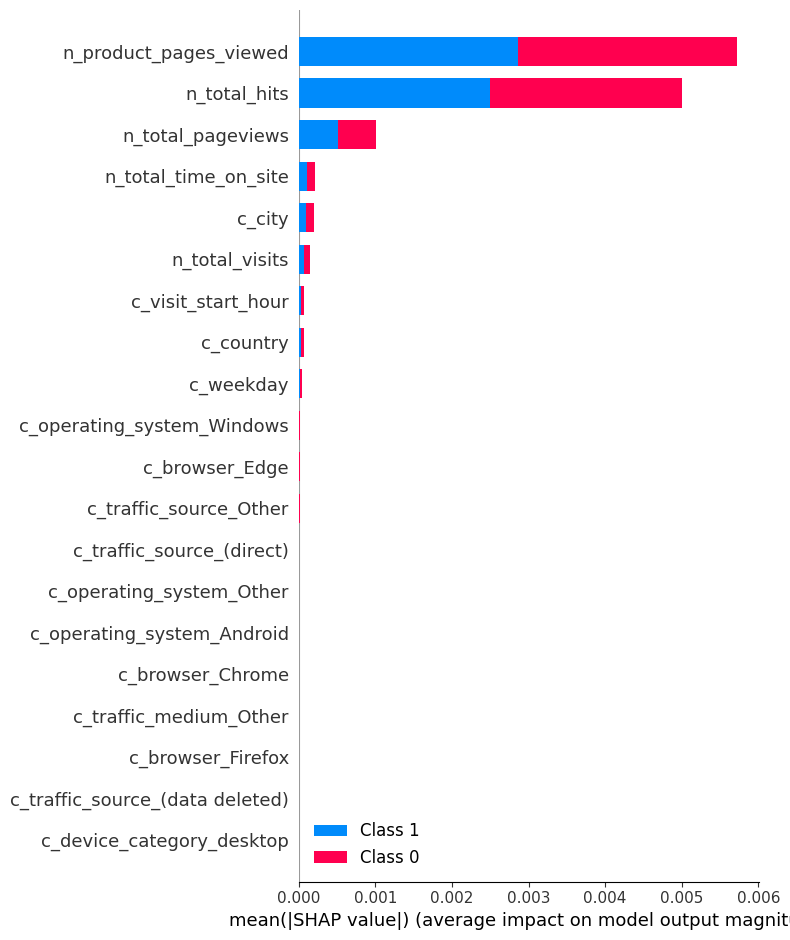

In [78]:
shap.summary_plot(shap_values, features=features_sample)

In [76]:
features_sample.columns[np.argsort(np.abs(shap_values).mean(0))]

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


array([['c_browser_Android Webview', 'c_country', 'c_city', ...,
        'n_total_pageviews', 'n_total_hits', 'n_product_pages_viewed'],
       ['c_browser_Android Webview', 'c_country', 'c_city', ...,
        'n_total_pageviews', 'n_total_hits', 'n_product_pages_viewed'],
       ['c_browser_Android Webview', 'c_country', 'c_city', ...,
        'n_total_pageviews', 'n_total_hits', 'n_product_pages_viewed'],
       ...,
       ['c_browser_Android Webview', 'c_country',
        'c_traffic_source_google', ..., 'n_total_time_on_site',
        'n_product_pages_viewed', 'n_total_hits'],
       ['c_browser_Android Webview', 'c_city', 'c_traffic_source_google',
        ..., 'n_total_pageviews', 'n_total_hits',
        'n_product_pages_viewed'],
       ['c_browser_Android Webview', 'c_country', 'c_city', ...,
        'n_total_pageviews', 'n_product_pages_viewed', 'n_total_hits']],
      dtype=object)

In [87]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(features_sample.columns, sum(vals))), columns=['feature','importance'])
feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
feature_importance

,feature,importance
0,n_product_pages_viewed,0.286108
1,n_total_hits,0.249860
2,n_total_pageviews,0.050808
4,n_total_time_on_site,0.010853
23,c_city,0.009903
3,n_total_visits,0.007531
39,c_visit_start_hour,0.003662
22,c_country,0.003384
38,c_weekday,0.002155
12,c_operating_system_Windows,0.000887


In [92]:
feature_importance.index[:5].to_list()

[0, 1, 2, 4, 23]

In [88]:
# top_5_features = feature_importance["feature"].head(5).to_list()
top_5_features = feature_importance.index[:5].to_list()
top_5_features

['n_product_pages_viewed',
 'n_total_hits',
 'n_total_pageviews',
 'n_total_time_on_site',
 'c_city']

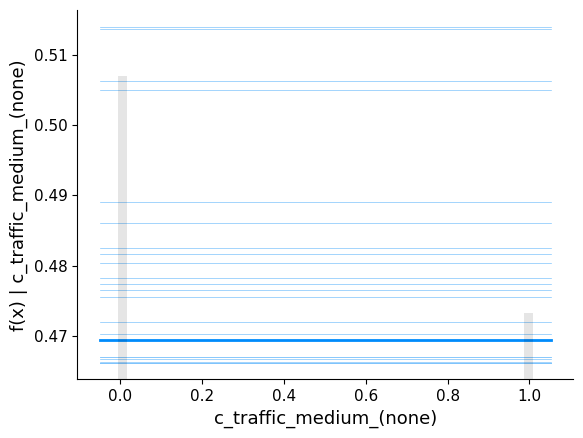

In [89]:
shap.plots.partial_dependence(30, lambda x: model.predict_proba(x)[:, 1], features_sample)

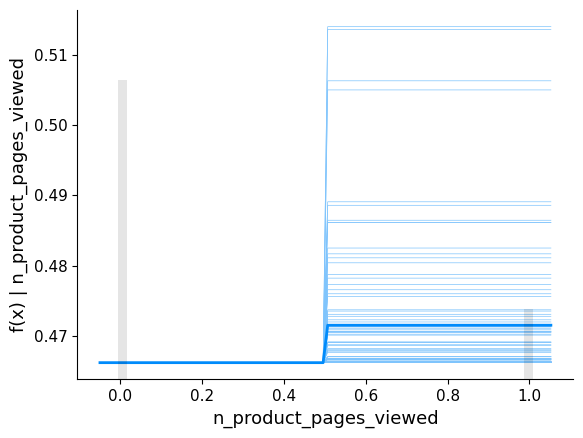

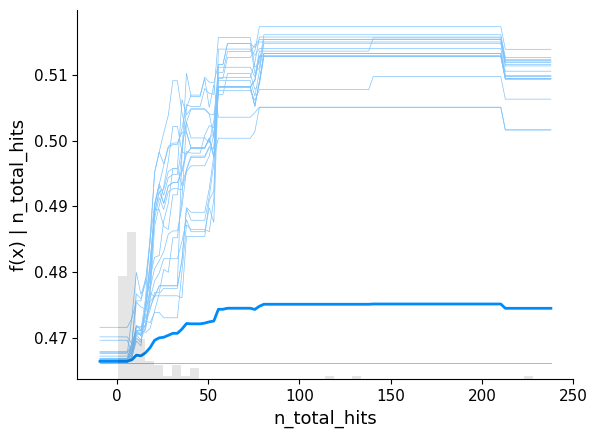

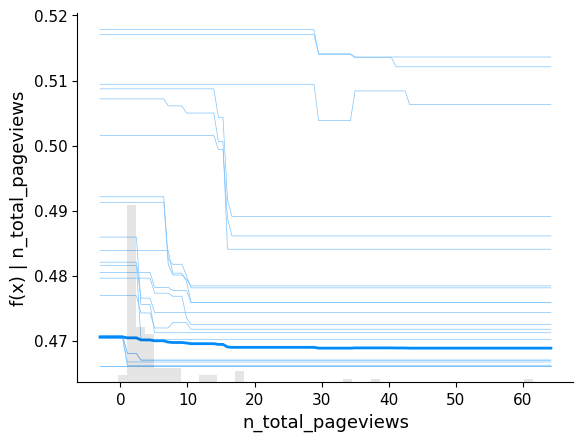

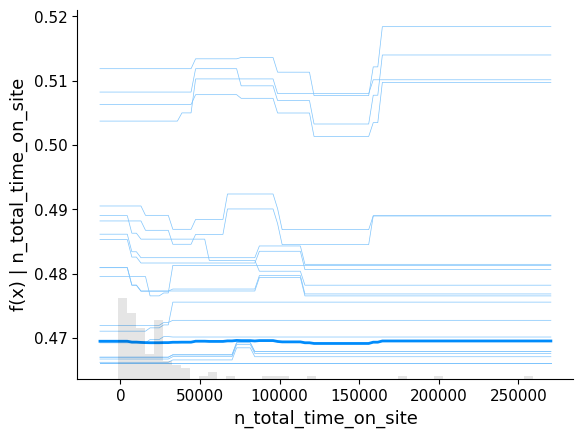

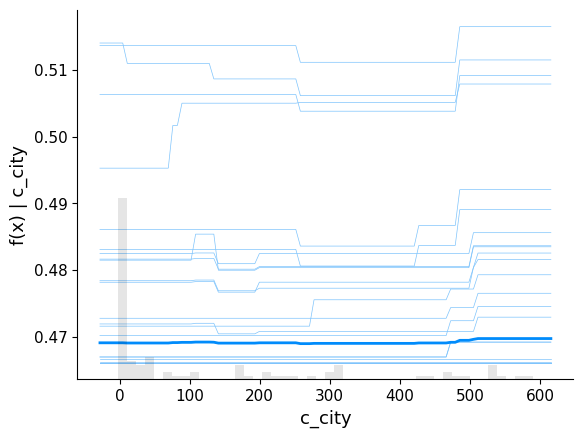

In [93]:
for idx in top_5_features:
    shap.plots.partial_dependence(idx, lambda x: model.predict_proba(x)[:, 1], features_sample)